# Random Forest

## Import and load data

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
housing_prices_df_raw = pd.read_csv('../src/data/train.csv')
test_housing_prices_df_raw = pd.read_csv('../src/data/test.csv')

In [61]:
train_hdf = housing_prices_df_raw.copy()
test_hdf = test_housing_prices_df_raw.copy()

In [62]:
hdf = pd.concat([train_hdf, test_hdf], axis = 0, sort = False)
hdf_eda = hdf.copy()

## Inspect data frame

In [64]:
hdf.shape

(2919, 81)

In [65]:
hdf.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [66]:
hdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
Id               2919 non-null int64
MSSubClass       2919 non-null int64
MSZoning         2915 non-null object
LotFrontage      2433 non-null float64
LotArea          2919 non-null int64
Street           2919 non-null object
Alley            198 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2917 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
OverallQual      2919 non-null int64
OverallCond      2919 non-null int64
YearBuilt        2919 non-null int64
YearRemodAdd     2919 non-null int64
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2918 non-

## Identify features by variable type

In [67]:
ord_feat_num = ['OverallQual', 'OverallCond', 'BsmtFullBath', 
        'BsmtHalfBath', 'FullBath', 'HalfBath',
        'TotRmsAbvGrd', 'Fireplaces', 'BedroomAbvGr', 
        'KitchenAbvGr', 'GarageCars']

ord_feat_cat = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
        'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
        'HeatingQC', 'KitchenQual', 'FireplaceQu', 
        'GarageQual', 'GarageCond', 'PoolQC']

ord_feat = ord_feat_num + ord_feat_cat

nom_feat = ['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 
       'LandContour', 'Utilities', 'Neighborhood', 
       'Condition1', 'Condition2', 'BldgType', 'RoofStyle', 
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
       'Foundation', 'Heating', 'CentralAir', 'Electrical', 
       'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition', 
       'GarageFinish', 'PavedDrive', 'Fence', 'Functional', 
       'HouseStyle','LotConfig', 'Street', 'LandSlope']

cont_feat = ['LotFrontage', 'LotArea', 'YearBuilt', 
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 
       'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 
       'GarageYrBlt', 'WoodDeckSF', 'OpenPorchSF', 
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 
       'MiscVal', 'MoSold', 'YrSold','BsmtUnfSF', 'GarageArea', 
       'LowQualFinSF', 'GrLivArea']

## Exploratory Data Analysis

### Continuous features

Check for distribution of data set:

Check for correlation:

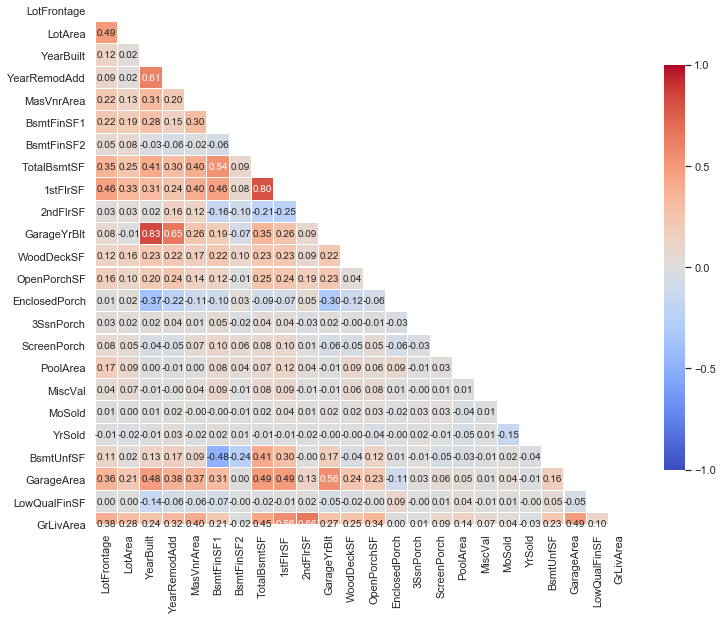

In [69]:
# Compute correlation matrix 
corr = hdf_eda[cont_feat].corr()

# Create mask to hide upper triangle
mask = np.zeros(corr.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True

# Set background to white
sns.set_style(style = 'white')

# Adjust plot dimensions
fig, ax = plt.subplots(figsize = (12,6))
fig.subplots_adjust(top=2.0)

# Create correlation matrix
sns.heatmap(corr, annot=True, fmt='.2f', mask=mask, ax=ax, cmap='coolwarm', 
            vmin = -1, vmax = 1, center = 0, square=True, linewidth=.1, 
            cbar_kws = {'shrink': .5,'ticks': [-1, -.5, 0, 0.5, 1]},
           )
# ax.set_xticklabels(corr.columns, rotation = 45)

In [70]:
# List top 10 positive correlations
corr_asc = corr.abs().where(np.triu(np.ones(corr.abs().shape), k=1).astype(np.bool)).stack().sort_values(ascending=False)
print(corr_asc[:10])
# Filter positive correlations over 0.69
corr_asc[corr_asc > 0.69] 

YearBuilt     GarageYrBlt     0.834812
TotalBsmtSF   1stFlrSF        0.801670
2ndFlrSF      GrLivArea       0.655085
YearRemodAdd  GarageYrBlt     0.652365
YearBuilt     YearRemodAdd    0.612235
1stFlrSF      GrLivArea       0.562538
GarageYrBlt   GarageArea      0.555836
BsmtFinSF1    TotalBsmtSF     0.536467
1stFlrSF      GarageArea      0.492011
LotFrontage   LotArea         0.489896
dtype: float64


YearBuilt    GarageYrBlt    0.834812
TotalBsmtSF  1stFlrSF       0.801670
dtype: float64

### Categorical features

Check for correlation between categorical variables:

In [10]:
pd.crosstab()

TypeError: crosstab() missing 2 required positional arguments: 'index' and 'columns'

## Data cleaning

### Impute missing values

In [71]:
# Check NAs by count
NA_count = hdf.isnull().sum()[hdf.isnull().sum() > 0]

# By percentage
round(100*NA_count/len(hdf), 2)

MSZoning         0.14
LotFrontage     16.65
Alley           93.22
Utilities        0.07
Exterior1st      0.03
Exterior2nd      0.03
MasVnrType       0.82
MasVnrArea       0.79
BsmtQual         2.77
BsmtCond         2.81
BsmtExposure     2.81
BsmtFinType1     2.71
BsmtFinSF1       0.03
BsmtFinType2     2.74
BsmtFinSF2       0.03
BsmtUnfSF        0.03
TotalBsmtSF      0.03
Electrical       0.03
BsmtFullBath     0.07
BsmtHalfBath     0.07
KitchenQual      0.03
Functional       0.07
FireplaceQu     48.65
GarageType       5.38
GarageYrBlt      5.45
GarageFinish     5.45
GarageCars       0.03
GarageArea       0.03
GarageQual       5.45
GarageCond       5.45
PoolQC          99.66
Fence           80.44
MiscFeature     96.40
SaleType         0.03
SalePrice       49.98
dtype: float64

Impute missing values for `LotFrontage`:

In [72]:
# Create df with LotArea and LotFrontage
from sklearn.linear_model import LinearRegression
inp_LotFrontage = LinearRegression()
a = pd.DataFrame({'LotArea':  np.log1p(hdf['LotArea']), 'LotFrontage':np.log1p(hdf['LotFrontage'])})
a = a.loc[a['LotArea'] < 12.1,:]

# Splitting data by missing and non-missingness
a_train = a.loc[~a['LotFrontage'].isnull(),:]
a_inp = a.loc[a['LotFrontage'].isnull(),:]

# Generate values to impute by fitting a model
inp_LotFrontage.fit(a_train[['LotArea']], a_train['LotFrontage'])

# Impute values
hdf.loc[hdf['LotFrontage'].isnull(), 'LotFrontage'] = np.expm1(inp_LotFrontage.predict(a_inp[['LotArea']]))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


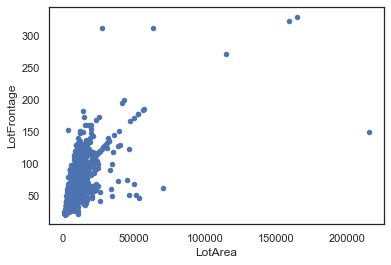

In [73]:
hdf.plot(kind = 'scatter', x = 'LotArea', y = 'LotFrontage')

Insert text here later:

In [74]:
# Convert ord_feat_num to ord_feat
hdf[ord_feat_cat] = hdf[ord_feat_cat].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, np.nan: 0})
hdf[['BsmtExposure']] = hdf[['BsmtExposure']].replace({'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, np.nan: 0})
hdf[['BsmtFinType1', 'BsmtFinType2']] = hdf[['BsmtFinType1', 'BsmtFinType2']].replace({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, np.nan: 0})

In [75]:
# Convert fence to nominal
hdf[['Fence']] = hdf[['Fence']].replace({'MnPrv': 'HasFence', 'GdWo': 'HasFence', 'GdPrv': 'HasFence', 'MnWw': 'HasFence', np.nan: 'NoFence'})

Impute missing values for remaining columns:

In [76]:
from scipy import stats

In [77]:
for col in set(hdf.columns) - {'SalePrice'}:
    if hdf[col].dtype == 'object':
        hdf.fillna({col:stats.mode(hdf[col]).mode[0]}, inplace = True)
    else:
        hdf.fillna({col:np.median(hdf.loc[~hdf[col].isnull(), col])}, inplace = True)

## Data preprocessing

### Generate features

In [78]:
hdf['Remodeled'] = pd.Series([1 if a > 0 else 0 for a in (hdf['YearRemodAdd'] - hdf['YearBuilt'])])
hdf['TotalPorchAreasSF'] = hdf['OpenPorchSF'] + hdf['EnclosedPorch'] + hdf['3SsnPorch'] + hdf['ScreenPorch'] + hdf['WoodDeckSF']
hdf ['TotalBath'] = hdf['FullBath'] + hdf['BsmtFullBath'] + .5*(hdf['HalfBath'] + hdf['BsmtHalfBath'])
hdf['OtherRoomsAbvGrd'] = hdf['TotRmsAbvGrd'] - hdf['KitchenAbvGr'] - hdf['FullBath']

Drop redundant features:

In [79]:
hdf.drop(columns = ['Utilities', 'Street', 'PoolQC'], inplace = True)
hdf.drop(columns = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'], inplace = True) # There is totalbsmt
hdf.drop(columns = ['FullBath', 'BsmtFullBath', 'HalfBath','BsmtHalfBath'], inplace = True)
hdf.drop(columns = ['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'WoodDeckSF'], inplace = True)
hdf.drop(columns = 'MiscFeature', inplace = True) # Drop feature (since price of feature is in Miscval)
hdf.drop(columns = 'TotRmsAbvGrd', inplace = True)

Check for NAs:

In [80]:
round(100*hdf.isnull().sum()[hdf.isnull().sum() > 0]/len(hdf), 2)

SalePrice    49.98
dtype: float64

Trim feature list:

In [81]:
ord_feat_num = set(ord_feat_num).union(set(['TotalBath', 'OtherRoomsAbvGrd', 'Remodeled'])) - \
set(['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'TotRmsAbvGrd',' KitchenAbvGr', 'GarageCars'])

ord_feat_cat = set(ord_feat_cat) - set(['PoolQC'])

ord_feat = ord_feat_num.union(ord_feat_cat)

nom_feat = set(nom_feat) - set(['Utilities','MiscFeature','Street'])

cont_feat = list(set(cont_feat).union(set(['TotalPorchAreasSF'])) - set(['Utilities', 'Street', 'PoolQC'] +\
['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'] +\
['FullBath', 'BsmtFullBath', 'HalfBath','BsmtHalfBath'] +\
['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'WoodDeckSF'] +\
['MiscFeature', 'TotRmsAbvGrd']))

### Define features and target

Define training data features and target:

In [82]:
# Define training data features
X_train = hdf.loc[~hdf['SalePrice'].isnull(), :]
# Drop outliers
# X_train = X_train.loc[(X_train['GrLivArea'] < 4000) & (X_train['LotArea'] < 100000) & (X_train['LotFrontage'] < 250),:]

# Define training data target
y_train = np.log1p(X_train.loc[~X_train['SalePrice'].isnull(), 'SalePrice'])

# Drop unnecessary columns
X_train.drop(columns = ['SalePrice'], inplace = True)

Define test data features and target:

In [83]:
X_test = hdf.loc[hdf['SalePrice'].isnull(), :].drop(columns = ['SalePrice'])

Check dimensions of training and testing sets:

In [84]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)

Training Features Shape: (1451, 67)
Training Labels Shape: (1451,)
Testing Features Shape: (1459, 67)


### Encode categorical features

Identify features by variable type:

In [85]:
import category_encoders as ce

#### Ordinal

- Ordinal Encoder: [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)

In [86]:
ord_enc = ce.OrdinalEncoder(cols=ord_feat).fit(X_train,y_train)
X_train = ord_enc.transform(X_train)

X_test = ord_enc.transform(X_test)

#### Nominal

- CatBoost Encoder: [Documentation](https://contrib.scikit-learn.org/categorical-encoding/catboost.html), [explanation via example](https://medium.com/whats-your-data/working-with-categorical-data-catboost-8b5e11267a37)

In [87]:
perm = np.random.permutation(len(X_train))
X_train = X_train.iloc[perm].reset_index(drop=True)
y_train = y_train.iloc[perm].reset_index(drop=True)

nom_enc = ce.CatBoostEncoder(cols=nom_feat).fit(X_train,y_train)
X_train = nom_enc.transform(X_train)

X_test = nom_enc.transform(X_test)

In [88]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1451 entries, 0 to 1450
Data columns (total 67 columns):
Id                   1451 non-null int64
MSSubClass           1451 non-null float64
MSZoning             1451 non-null float64
LotFrontage          1451 non-null float64
LotArea              1451 non-null int64
Alley                1451 non-null float64
LotShape             1451 non-null float64
LandContour          1451 non-null float64
LotConfig            1451 non-null float64
LandSlope            1451 non-null float64
Neighborhood         1451 non-null float64
Condition1           1451 non-null float64
Condition2           1451 non-null float64
BldgType             1451 non-null float64
HouseStyle           1451 non-null float64
OverallQual          1451 non-null int64
OverallCond          1451 non-null int64
YearBuilt            1451 non-null int64
YearRemodAdd         1451 non-null int64
RoofStyle            1451 non-null float64
RoofMatl             1451 non-null float64
Ex

In [89]:
X_train.drop(columns = ['Id'], inplace = True)

## Model: Random Forest

In [90]:
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint

In [91]:
# Create base model
rf = RandomForestRegressor()

In [92]:
# Check out base/default parameters
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


### Choose hyperparameters

Narrow down search for wide range of values for hyperparameters:

In [41]:
from sklearn.model_selection import RandomizedSearchCV

In [42]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 2000, stop = 3500, num = 10)]
# Number of features to consider at every split
max_features = [7, 8, 9, 10, 11, 12, 15, 16, 20, 22]
# # Maximum number of levels in a tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [8, 9, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 100, num = 10)]
# Experimenting with random_state
random_state = [0, 10, 50, 100]

In [43]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
#                'max_depth': max_depth,
               'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
               'random_state': random_state}

In [44]:
pprint(random_grid)

{'max_features': [7, 8, 9, 10, 11, 12, 15, 16, 20, 22],
 'min_samples_split': [8, 9, 10],
 'n_estimators': [2000, 2166, 2333, 2500, 2666, 2833, 3000, 3166, 3333, 3500],
 'random_state': [0, 10, 50, 100]}


In [45]:
# Use the random grid to search for best hyperparameters
# Random search of parameters, using 5-fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, cv = 5, verbose=2, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 15.0min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...r

In [46]:
rf_random.best_params_

{'random_state': 50,
 'n_estimators': 3500,
 'min_samples_split': 8,
 'max_features': 16}

Evaluate combination of settings from randomized search:

In [47]:
from sklearn.model_selection import GridSearchCV

In [93]:
# Create parameter grid based on results of random search
param_grid = {
#     'random_state': [0, 10, 50, 100],
#     'bootstrap': [True],
#     'max_depth': list(range(10, 120, 10)),
    'max_features': [16, 17, 18, 19],
    'min_samples_split': [4,5,6, 7],
    'min_samples_leaf': [1, 2, 3],
    'n_estimators': [3500]
}

# Initlize grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 5, n_jobs = -1, verbose = 2)

In [94]:
pprint(param_grid)

{'max_features': [16, 17, 18, 19],
 'min_samples_leaf': [1, 2, 3],
 'min_samples_split': [4, 5, 6, 7],
 'n_estimators': [3500]}


In [ ]:
#Fit grid search to data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.7min
/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  7.7min


In [63]:
grid_search.best_params_

{'max_features': 17,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 3300}

Record results of trial and error:

### Make predictions

Predict test values:

In [ ]:
predictions = rf.predict(X_test)

Calculate absolute errors:

In [ ]:
abs_err = abs(predictions - y_test)

Calculate mean absolute error:

In [ ]:
print('Mean Absolute Error:', round(np.mean(abs_err), 2), 'degrees.')

Calculate relative feature importance:

In [ ]:
# 
importances = list(rf.feature_importances_)

# 

# Sort by descending order
sorted(, key = lambda f: f[1], reverse = True)

# Print
[print(f'Feature: {:} Importance: {}') for pair in ]

### Evaluate model performance

Calculate mean absolute percentage error (MAPE):

In [ ]:
mape = (abs_errors/y_test)*100

Calculate and display accuracy:

In [ ]:
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2),'%.')

### Data visualization

#### Feature importance

In [ ]:
importance:

# feature_importance = list(zip(spam_train.columns[:-2], randomForest.feature_importances_))
# dtype = [('feature', 'S10'), ('importance', 'float')]
# feature_importance = np.array(feature_importance, dtype=dtype)
# feature_sort = np.sort(feature_importance, order='importance')[::-1]
# name, score = zip(*list(feature_sort))
# pd.DataFrame({'name':name,'score':score})[:15].plot.bar(x='name', y='score')